# Transformers

In [1]:
import os
import sys

os.chdir("..")
sys.path.append(os.getcwd())
os.getcwd()

'/group/pmc026/nchoong/QuantumTransformer'

In [2]:
from transformer.pytorch.main_no_embed import main
from transformer.pytorch.utils.plots import plot_metrics
from transformer.pytorch.utils.load_dataloader import load_dataloader

2024-10-06 23:24:44.385824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 23:24:44.399690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 23:24:44.415652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 23:24:44.420516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 23:24:44.433140: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from config import dev

dev

device(type='cuda')

In [4]:
import random
import numpy as np
import torch
import tensorflow as tf

In [5]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

[<torch.cuda.device at 0x7f9fcf39b350>, <torch.cuda.device at 0x7f9e4dfa6d10>]

In [6]:
seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTEROP_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTRAOP_THREADS"] = str(os.cpu_count())

tf.config.threading.set_intra_op_parallelism_threads(os.cpu_count())
tf.config.threading.set_inter_op_parallelism_threads(os.cpu_count())

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
train_dataloader, val_dataloader, test_dataloader = load_dataloader("imdb")

Loading train tensors: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Sample size:  5000


Loading test tensors: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Test size:  5000
Sampled train tensor shape:  torch.Size([20000, 128, 768])
Sampled val tensor shape:  torch.Size([5000, 128, 768])
Sampled test tensor shape:  torch.Size([5000, 128, 768])
Train, Val, Test size:  20000 5000 5000
pos:  10006
neg:  9994
pos:  2494
neg:  2506
pos:  2515
neg:  2485


## Classical

In [16]:
train_loss, train_acc, val_loss, val_acc, train_auc, val_auc, best_dict = main(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    n_epochs=20,
    sample_size=0,
    batch_size=64,
    embed_dim=2**8,
    num_heads=2,
    num_blocks=2,
    pooling_method="MAX",
    tqdm_disabled=False,
    batch=True,
)

classiscal_metrics = {
    "train_loss": train_loss,
    "train_acc": train_acc,
    "val_loss": val_loss,
    "val_acc": val_acc,
    "train_auc": train_auc,
    "val_auc": val_auc,
    "best_dict": best_dict,
}

++ There will be 2 transformer blocks
TextClassifier(
  (squeeze): Linear(in_features=768, out_features=256, bias=True)
  (transformers): ModuleList(
    (0-1): 2 x Encoder(
      (attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-2): 3 x Linear(in_features=256, out_features=256, bias=False)
        )
        (combine_heads): Linear(in_features=256, out_features=256, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (ffn): FeedForward(
        (linear_1): Linear(in_features=256, out_features=16, bias=True)
        (linear_2): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNor

Epoch  20/20: 100%|██████████| 313/313 [00:07<00:00, 41.32batch/s, Epoch = 0m 7s, Loss = 0.5157|0.5802, Acc = 0.745|0.719, AUC = 82.335|80.182]

TOTAL TIME = 219.00s
BEST ACC = 0.77% AT EPOCH 2
BEST AUC = 86.89 AT EPOCH 2


In [ ]:
plot_metrics(train_loss, val_loss, train_acc, val_acc, train_auc, val_auc)


## Quantum with Pennylane GPU

In [8]:
train_loss, train_acc, val_loss, val_acc, train_auc, val_auc, best_dict = main(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    n_epochs=20,
    sample_size=0,
    batch_size=64,
    embed_dim=2**8,
    num_heads=2,
    num_blocks=2,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=3,
    tqdm_disabled=False,
    q_device="default.qubit",
    batch=True,
    circuit_type="pennylane",
    encoding_type="angle_amp",
    pennylane_args={
        "hadamard": False,
        "encoder": "amplitude",
        "angle_rot": "X",
        "entangler": "basic",
        "rot": "Z",
        "imprimitive": "X",
    },
)

quantum_pl_gpu_metrics_batch = {
    "train_loss": train_loss,
    "train_acc": train_acc,
    "val_loss": val_loss,
    "val_acc": val_acc,
    "train_auc": train_auc,
    "val_auc": val_auc,
    "best_dict": best_dict,
}

++ There will be 2 transformer blocks
++ Transformer will use 8 qubits and 3 q layers
The feed-forward head will use 8 qubits
Using PennyLane quantum device default.qubit
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
TextClassifier(
  (squeeze): Linear(in_features=768, out_features=256, bias=True)
  (transformers): ModuleList(
    (0-1): 2 x Encoder(
      (attn): MultiHeadedAttention(
        (k_linear): QuantumLayer(
          (linear): <Quantum Torch Layer: func=qlayer>
        )
        (q_linear): QuantumLayer(
          (linear): <Quantum Torch Layer: func=qlayer>
        )
        (v_linear): QuantumLayer(
          (linear): <Quantum Torch Layer: func=qlayer>
        )
        (combine_heads): QuantumLayer(
          (linear): <Quantum Torch Layer: func=qlayer>
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (unsqueeze1): Linear(in_features=4, out_features=128, bias=True)
        (unsqueeze2): Linear(in_features

Epoch   1/20: 100%|██████████| 313/313 [05:03<00:00,  1.11batch/s]/home/nchoong/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nchoong/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch   2/20: 100%|██████████| 313/313 [05:00<00:00,  1.25batch/s]/home/nchoong/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nchoong/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch   3/20: 100%|██████████| 313/313 [04:49<00:00,  1.13batch/s]/home/nchoong/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty sl

TOTAL TIME = 6170.89s
BEST ACC = 0.87% AT EPOCH 15
BEST AUC = 94.19 AT EPOCH 14


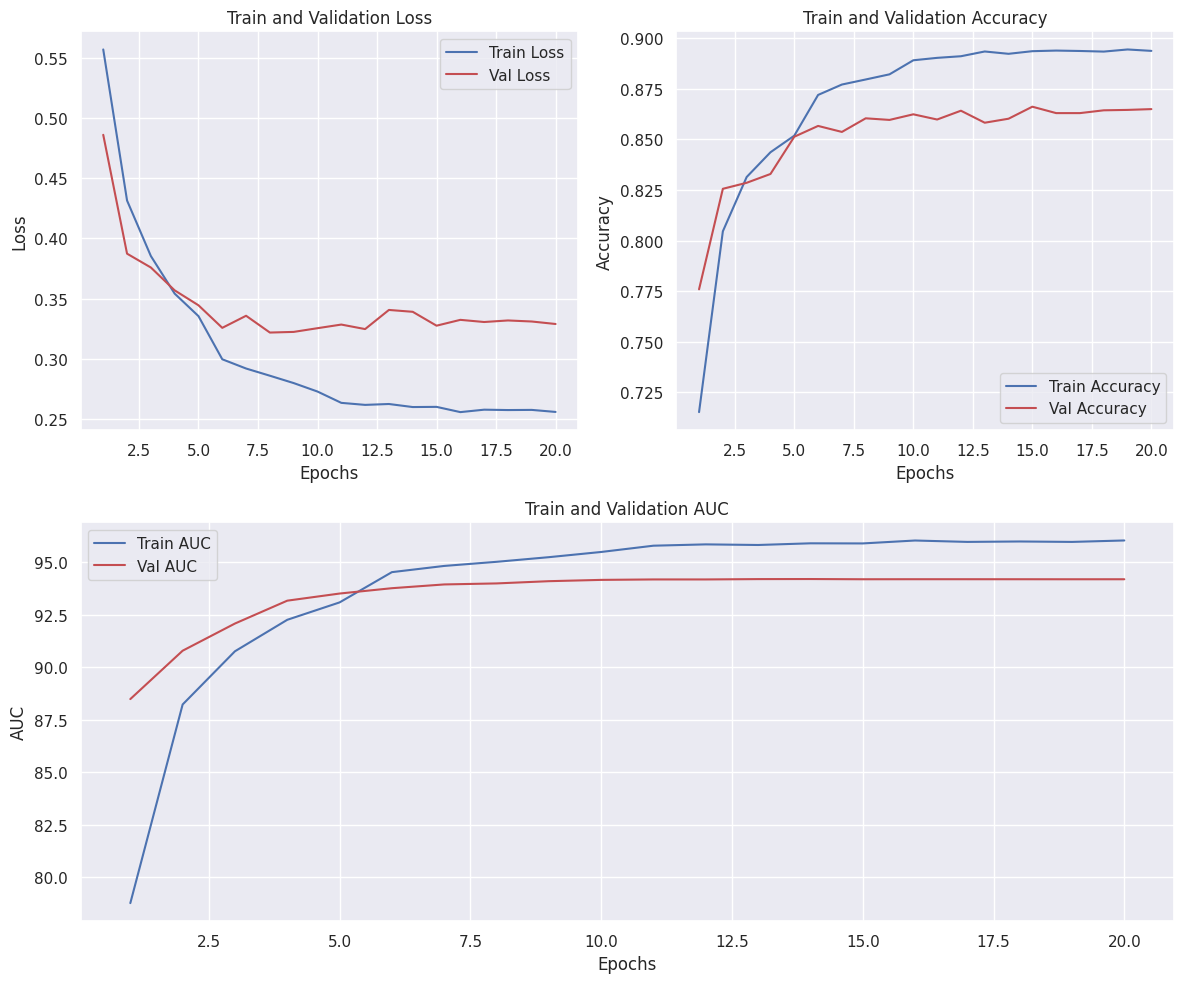

In [ ]:
plot_metrics(train_loss, val_loss, train_acc, val_acc, train_auc, val_auc)

In [10]:
quantum_pl_gpu_metrics_batch["best_dict"]["param_grads"]

[{'squeeze.weight': 0.654987341489274,
  'squeeze.bias': 0.027998472562434668,
  'transformers.0.attn.k_linear.linear.weights': 4.564995539525665e-11,
  'transformers.0.attn.q_linear.linear.weights': 1.517095018437434e-11,
  'transformers.0.attn.v_linear.linear.weights': 1.4127369628790573e-09,
  'transformers.0.attn.combine_heads.linear.weights': 2.989824331313994e-09,
  'transformers.0.attn.unsqueeze1.weight': 0.001362840517023474,
  'transformers.0.attn.unsqueeze1.bias': 0.00738653536873331,
  'transformers.0.attn.unsqueeze2.weight': 0.0021955316118076264,
  'transformers.0.attn.unsqueeze2.bias': 0.027041483475579716,
  'transformers.0.norm1.weight': 0.03538388649102884,
  'transformers.0.norm1.bias': 0.040494865639664875,
  'transformers.0.ffn.linear_1.weight': nan,
  'transformers.0.ffn.linear_1.bias': nan,
  'transformers.0.ffn.linear_2.weight': 0.0054593570731258905,
  'transformers.0.ffn.linear_2.bias': 0.03872940375413091,
  'transformers.0.ffn.vqc.linear.weights': 3.276643377

In [11]:
quantum_pl_gpu_metrics_batch["best_dict"]["param_updates"]

[{'squeeze.weight': 11.101396450981165,
  'squeeze.bias': 0.32598965884016723,
  'transformers.0.attn.k_linear.linear.weights': 2.2213215904113963,
  'transformers.0.attn.q_linear.linear.weights': 2.5546949610542566,
  'transformers.0.attn.v_linear.linear.weights': 2.5773326543192514,
  'transformers.0.attn.combine_heads.linear.weights': 2.3850259559984788,
  'transformers.0.attn.unsqueeze1.weight': 6.714165311271009,
  'transformers.0.attn.unsqueeze1.bias': 3.4962009378134633,
  'transformers.0.attn.unsqueeze2.weight': 9.171868461389511,
  'transformers.0.attn.unsqueeze2.bias': 3.210214249242228,
  'transformers.0.norm1.weight': 16.022145429739176,
  'transformers.0.norm1.bias': 0.09658542130225764,
  'transformers.0.ffn.linear_1.weight': 1.6740992069244385,
  'transformers.0.ffn.linear_1.bias': 0.10116275399923325,
  'transformers.0.ffn.linear_2.weight': 9.192259977419917,
  'transformers.0.ffn.linear_2.bias': 3.3426197215010185,
  'transformers.0.ffn.vqc.linear.weights': 2.270537180

In [12]:
import matplotlib.pyplot as plt

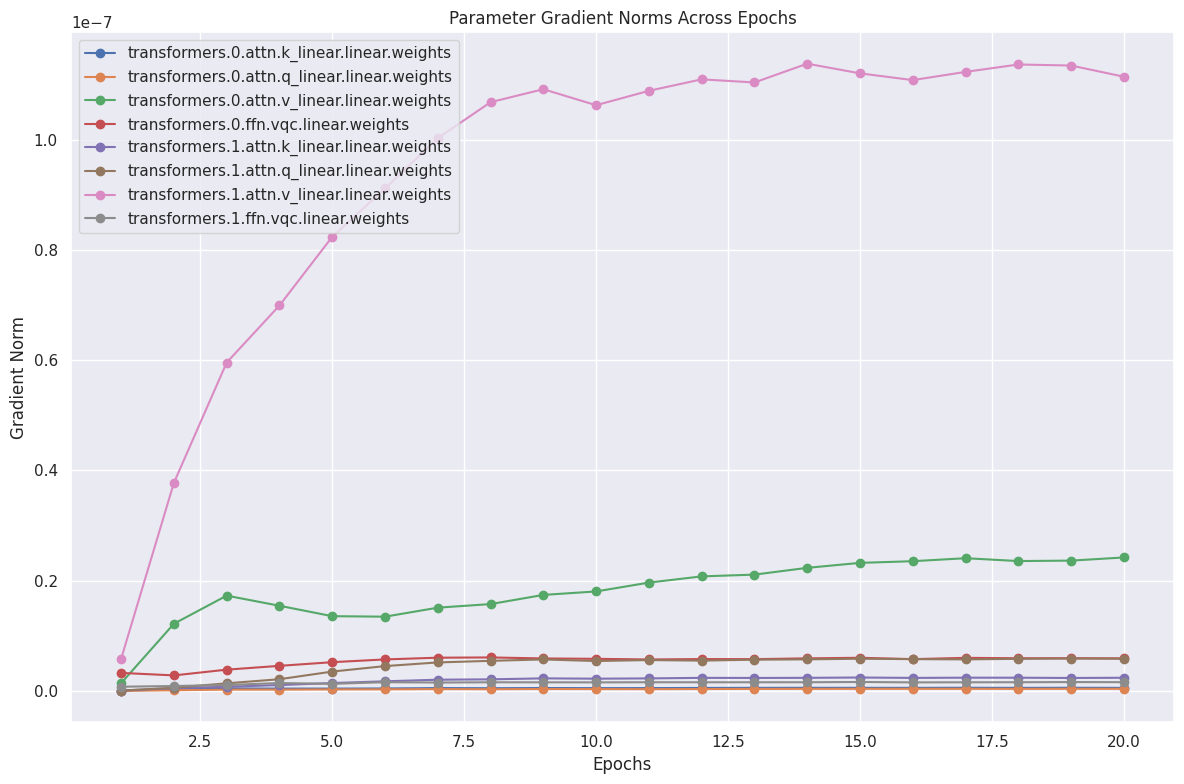

In [13]:
params_to_plot = [
    "transformers.0.attn.k_linear.linear.weights",
    "transformers.0.attn.q_linear.linear.weights",
    "transformers.0.attn.v_linear.linear.weights",
    "transformers.0.ffn.vqc.linear.weights",
    "transformers.1.attn.k_linear.linear.weights",
    "transformers.1.attn.q_linear.linear.weights",
    "transformers.1.attn.v_linear.linear.weights",
    "transformers.1.ffn.vqc.linear.weights",
]

param_grads = quantum_pl_gpu_metrics_batch["best_dict"]["param_grads"]

# Prepare lists for each parameter across epochs
epochs = list(range(1, len(param_grads) + 1))

# Plot each parameter's gradient norm across epochs
plt.figure(figsize=(12, 8))

for param in params_to_plot:
    grad_values = [epoch[param] for epoch in param_grads]
    plt.plot(epochs, grad_values, marker="o", label=param)

plt.title("Parameter Gradient Norms Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

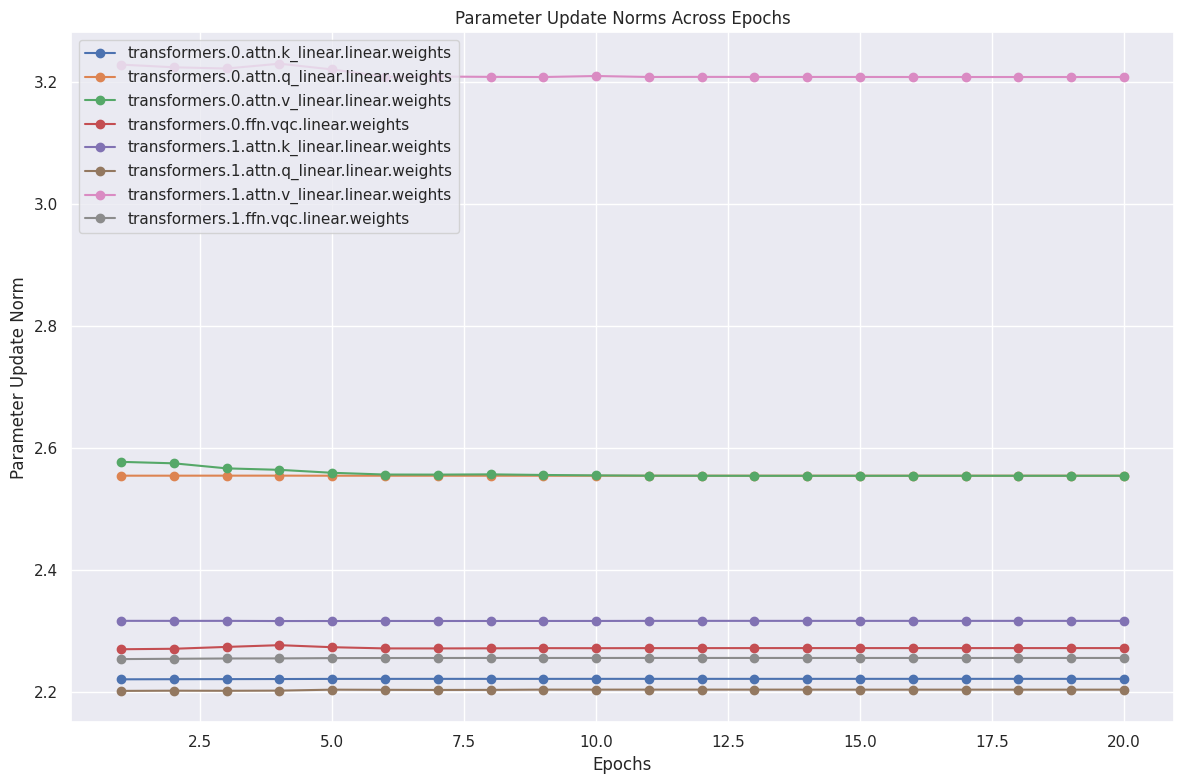

In [14]:
param_updates = quantum_pl_gpu_metrics_batch["best_dict"]["param_updates"]

# Prepare lists for each parameter across epochs
epochs = list(range(1, len(param_updates) + 1))

# Plot each parameter's gradient norm across epochs
plt.figure(figsize=(12, 8))

for param in params_to_plot:
    grad_values = [epoch[param] for epoch in param_updates]
    plt.plot(epochs, grad_values, marker="o", label=param)

plt.title("Parameter Update Norms Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Parameter Update Norm")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
for param in params_to_plot:
    grad_values = [epoch[param] for epoch in param_grads]
    print(param, grad_values)

transformers.0.attn.k_linear.linear.weights [4.564995539525665e-11, 3.292545380154563e-10, 4.6486135339558696e-10, 4.297960576362613e-10, 4.3081109264828473e-10, 4.534992417535569e-10, 5.250956311581882e-10, 4.994588166462907e-10, 5.340660998285149e-10, 5.155596879924467e-10, 5.225238020045708e-10, 5.503347081384996e-10, 5.653967602942424e-10, 5.746296146581463e-10, 5.708364340766547e-10, 5.650076238431007e-10, 5.831633875211621e-10, 5.648736335801264e-10, 5.78987760202984e-10, 5.648877948206417e-10]
transformers.0.attn.q_linear.linear.weights [1.517095018437434e-11, 1.3000848443150632e-10, 2.4847585732389827e-10, 2.473913357184343e-10, 2.82153048263105e-10, 2.9842137037142745e-10, 3.4236511305232144e-10, 3.195282505926743e-10, 3.5792328326417937e-10, 3.4469998853395504e-10, 3.27670924782896e-10, 3.5413003528895786e-10, 3.762864730933984e-10, 3.866224392462944e-10, 3.9521583525350275e-10, 3.9441560503062867e-10, 3.974182169011633e-10, 3.874052223409393e-10, 3.961585230521091e-10, 3.930